In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox

## need to change df to cleaned one

## and remove spam optionally

In [2]:
df = pd.read_csv(
    "../data/tickets.csv",
    sep=";",
    usecols=[0, 1],
    parse_dates=[0, 1],
    encoding="latin-1",
    header=None,
)
df.columns = ["date_req", "date_ans"]

## basic eda

In [3]:
df

,date_req,date_ans
0,2023-01-01 08:22:15+00:00,2023-01-01 19:14:50+00:00
1,2023-01-01 11:18:47+00:00,2023-01-01 19:18:36+00:00
2,2023-01-01 12:31:00+00:00,2023-01-01 18:52:48+00:00
3,2023-01-01 13:15:12+00:00,2023-01-01 18:51:01+00:00
4,2023-01-01 13:15:12+00:00,2023-01-01 18:52:00+00:00
...,...,...
10267,2024-09-29 14:01:01+00:00,2024-09-29 18:48:28+00:00
10268,2024-09-29 14:51:12+00:00,2024-09-29 18:47:30+00:00
10269,2024-09-29 20:20:16+00:00,2024-09-30 10:56:29+00:00
10270,2024-09-29 21:52:41+00:00,2024-09-29 22:04:55+00:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10272 entries, 0 to 10271
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   date_req  10272 non-null  datetime64[ns, UTC]
 1   date_ans  10272 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2)
memory usage: 160.6 KB


In [5]:
daily_counts = df["date_req"].dt.floor("D").value_counts().sort_index()
daily_counts.index = pd.to_datetime(daily_counts.index)

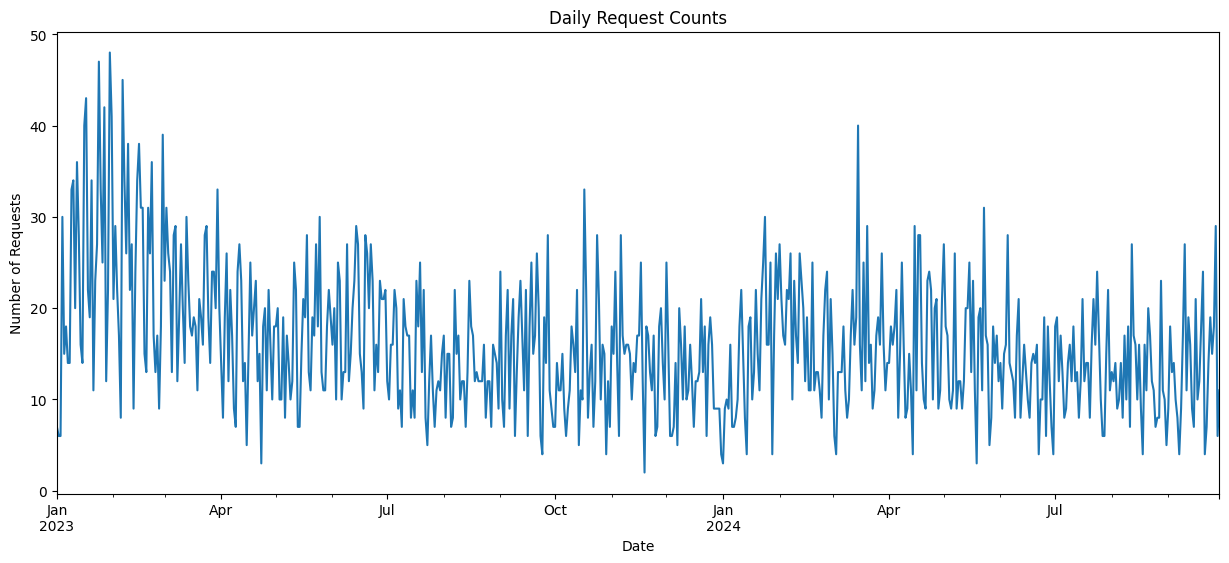

In [6]:
plt.figure(figsize=(15, 6))
daily_counts.plot()
plt.title("Daily Request Counts")
plt.xlabel("Date")
plt.ylabel("Number of Requests")
plt.show()

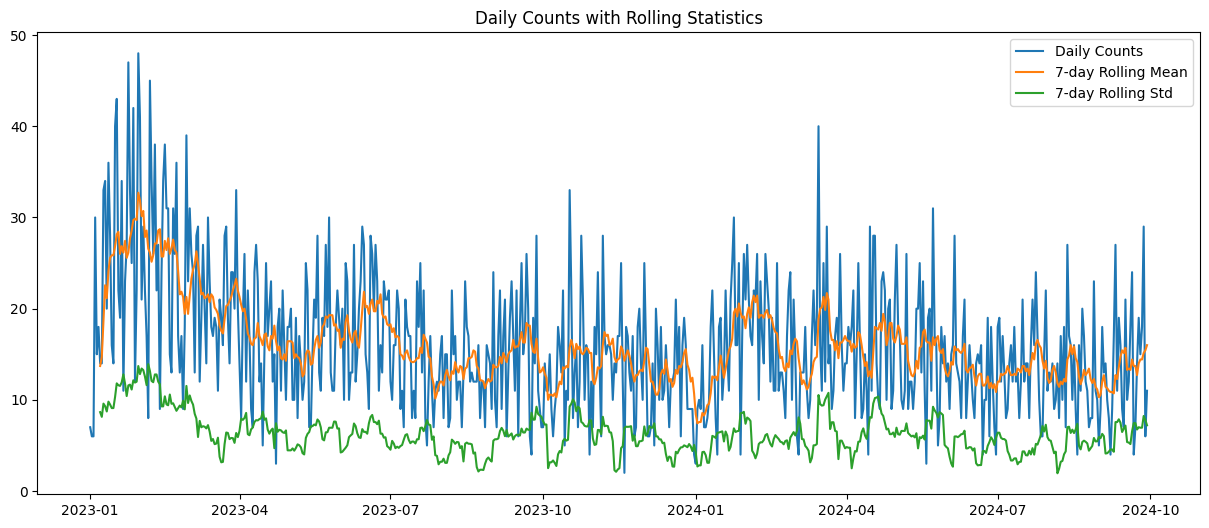

In [7]:
rolling_mean = daily_counts.rolling(window=7).mean()
rolling_std = daily_counts.rolling(window=7).std()

plt.figure(figsize=(15, 6))
plt.plot(daily_counts, label="Daily Counts")
plt.plot(rolling_mean, label="7-day Rolling Mean")
plt.plot(rolling_std, label="7-day Rolling Std")
plt.legend()
plt.title("Daily Counts with Rolling Statistics")
plt.show()

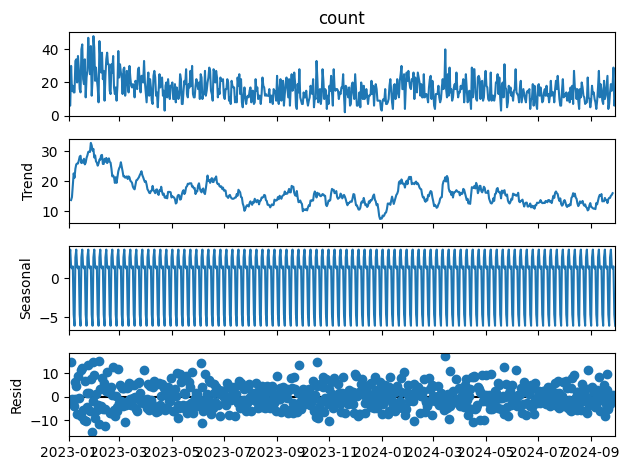

In [8]:
decomposition = seasonal_decompose(daily_counts, model="additive", period=7)
decomposition.plot()
plt.tight_layout()
plt.show()

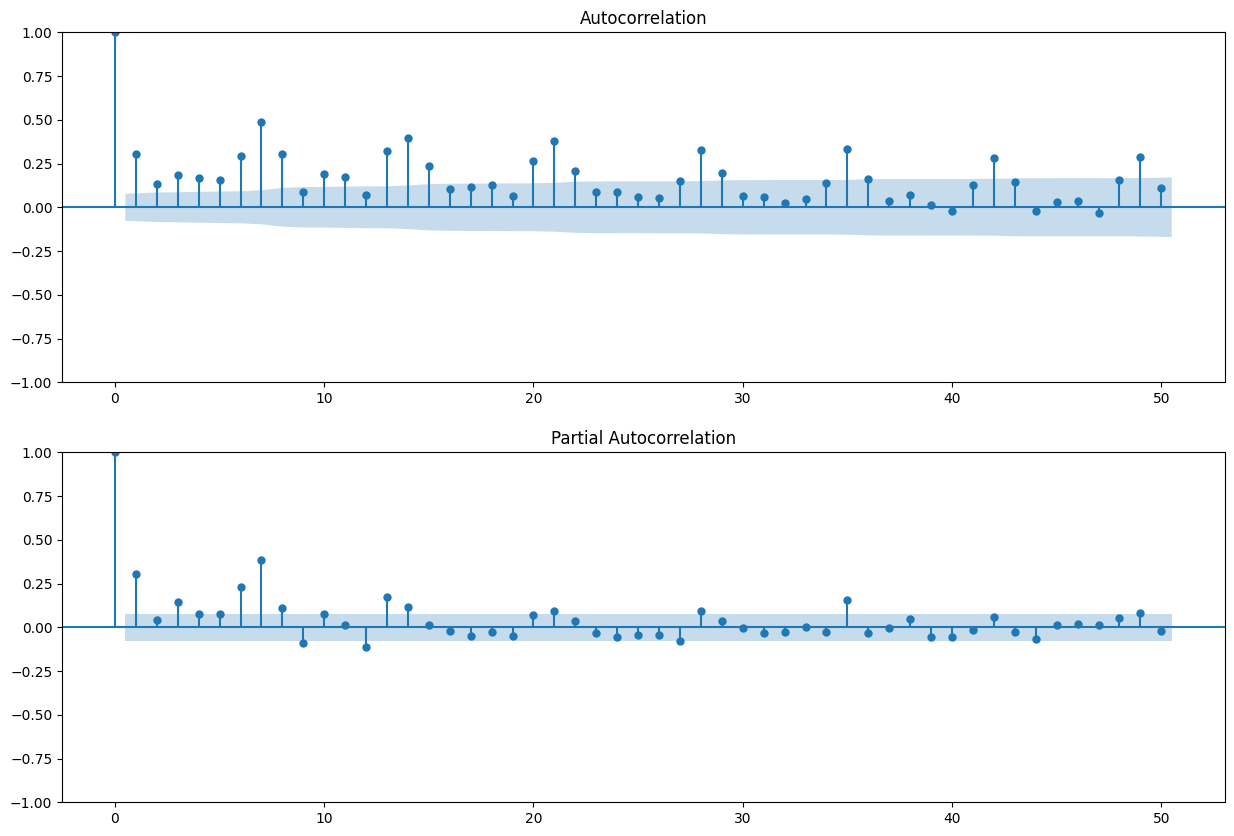

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(daily_counts, ax=ax1, lags=50)
plot_pacf(daily_counts, ax=ax2, lags=50)
plt.show()

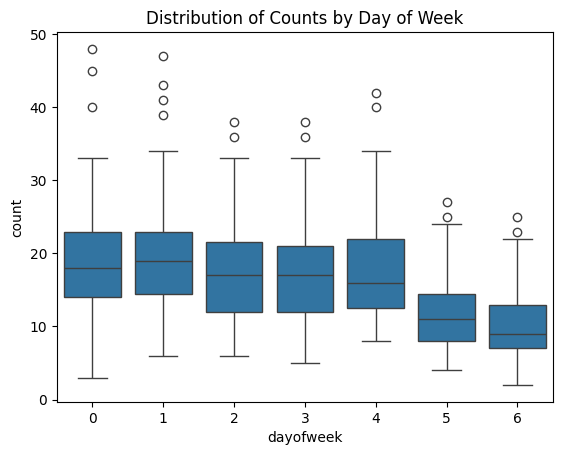

In [10]:
daily_counts.index = pd.to_datetime(daily_counts.index)
daily_counts_df = pd.DataFrame(
    {"count": daily_counts, "dayofweek": daily_counts.index.dayofweek}
)
sns.boxplot(x="dayofweek", y="count", data=daily_counts_df)
plt.title("Distribution of Counts by Day of Week")
plt.show()

/var/folders/kn/8xhddqln3jb_nvkv79lkj0l00000gn/T/ipykernel_21651/3183100269.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = daily_counts.resample("M").sum()


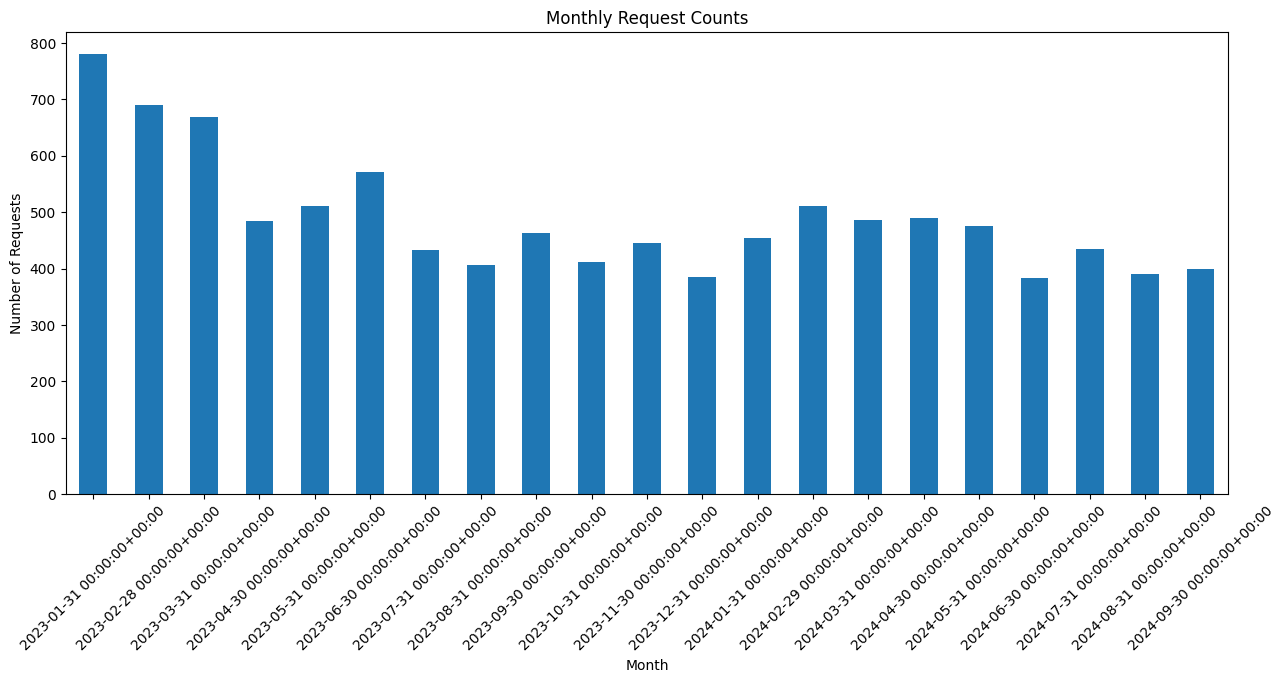

In [11]:
monthly_counts = daily_counts.resample("M").sum()
plt.figure(figsize=(15, 6))
monthly_counts.plot(kind="bar")
plt.title("Monthly Request Counts")
plt.xlabel("Month")
plt.ylabel("Number of Requests")
plt.xticks(rotation=45)
plt.show()


In [12]:
print(daily_counts.describe())

count    638.000000
mean      16.100313
std        7.512374
min        2.000000
25%       11.000000
50%       15.000000
75%       20.000000
max       48.000000
Name: count, dtype: float64


In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_counts.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])


ADF Statistic: -2.7543035460120726
p-value: 0.06510345765578694
Critical Values: {'1%': -3.440992973242412, '5%': -2.8662357332485353, '10%': -2.569270733669741}


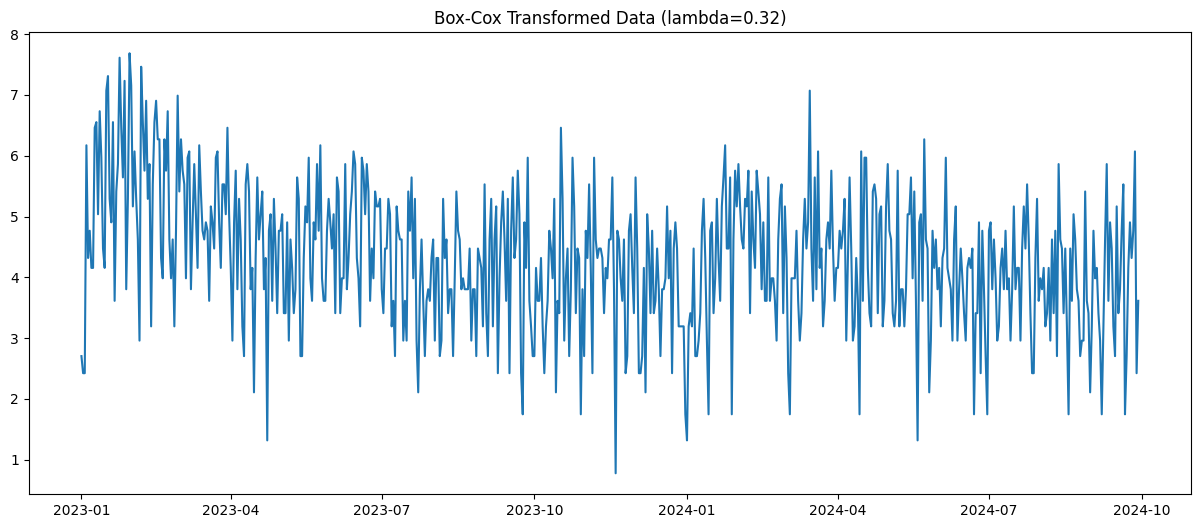

In [14]:
daily_counts_positive = daily_counts[
    daily_counts > 0
]  # Box-Cox requires positive values
transformed_data, lambda_param = boxcox(daily_counts_positive)

plt.figure(figsize=(15, 6))
plt.plot(daily_counts_positive.index, transformed_data)
plt.title(f"Box-Cox Transformed Data (lambda={lambda_param:.2f})")
plt.show()

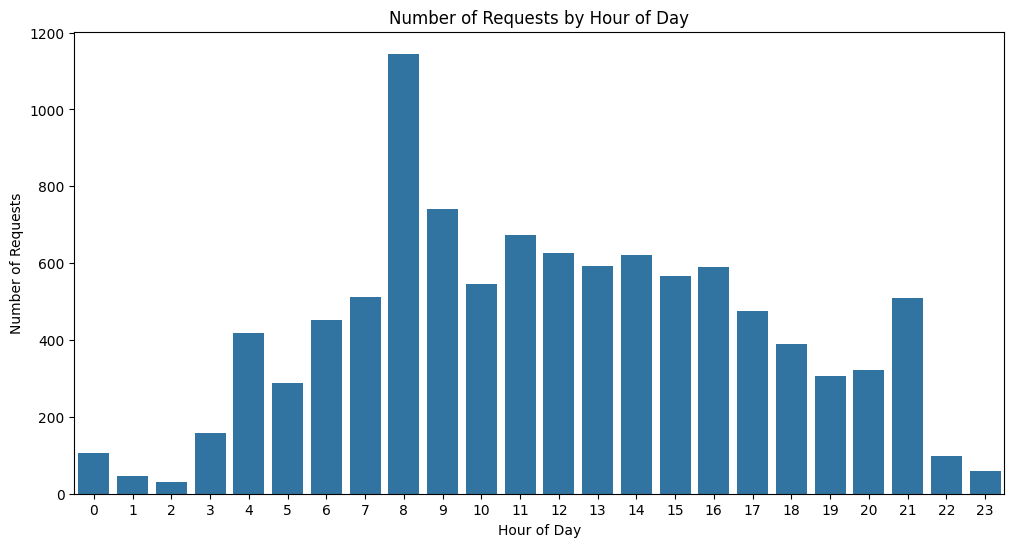

Hour with highest load: 8:00, with 1145 requests


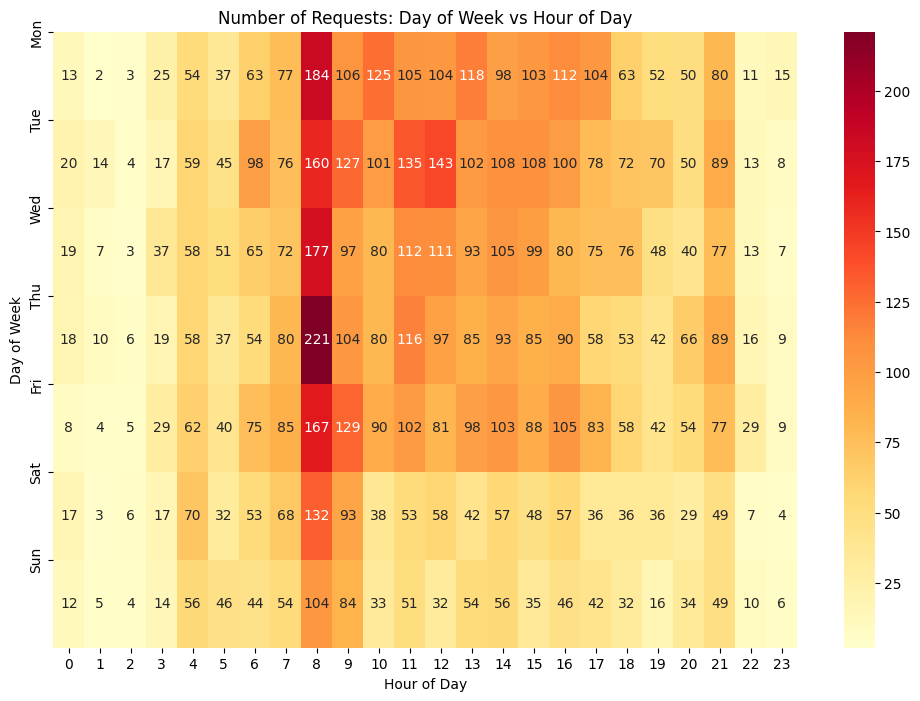

In [15]:
df["hour"] = df["date_req"].dt.hour

# Group by hour and count requests
hourly_counts = df.groupby("hour").size().reset_index(name="count")

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x="hour", y="count", data=hourly_counts)
plt.title("Number of Requests by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Requests")
plt.xticks(range(0, 24))
plt.show()

# Calculate and print the hour with the highest load
max_hour = hourly_counts.loc[hourly_counts["count"].idxmax()]
print(
    f"Hour with highest load: {max_hour['hour']}:00, with {max_hour['count']} requests"
)

# Create a heatmap for day of week vs hour of day
df["day_of_week"] = df["date_req"].dt.dayofweek
heatmap_data = df.groupby(["day_of_week", "hour"]).size().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt="g")
plt.title("Number of Requests: Day of Week vs Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.yticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()

In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


def evaluate_grouping(df, freq):
    # Group the data
    grouped = df["date_req"].dt.floor(freq).value_counts().sort_index()

    # Calculate total possible periods
    date_range = pd.date_range(
        start=df["date_req"].min(), end=df["date_req"].max(), freq=freq
    )
    total_possible_periods = len(date_range)

    # Calculate statistics
    mean = grouped.mean()
    std = grouped.std()
    cv = std / mean  # Coefficient of variation

    # Calculate percentage of periods with data
    periods_with_data = len(grouped)
    percentage_periods_with_data = (periods_with_data / total_possible_periods) * 100

    # Perform ADF test
    adf_result = adfuller(grouped.dropna())

    # Try seasonal decomposition
    try:
        if freq in ["D", "12h", "6h"]:
            period = 7
        elif freq == "4h":
            period = 42
        elif freq == "2h":
            period = 84
        else:
            period = 168

        decompose = seasonal_decompose(grouped, model="additive", period=period)
        seasonal_strength = 1 - np.var(decompose.resid) / np.var(
            decompose.seasonal + decompose.resid
        )
    except:
        seasonal_strength = np.nan

    return {
        "Frequency": freq,
        "Mean": mean,
        "Std Dev": std,
        "Coefficient of Variation": cv,
        "Percentage Periods with Data": percentage_periods_with_data,
        "ADF Statistic": adf_result[0],
        "ADF p-value": adf_result[1],
        "Seasonal Strength": seasonal_strength,
    }


# Assuming your DataFrame is called df and has a column 'date_req'
# If not, load it first:
# df = pd.read_csv('your_data.csv', parse_dates=['date_req'])

# List of frequencies to test
frequencies = ["D", "12h", "6h", "4h", "2h", "h"]

# Evaluate each frequency
results = []
for freq in frequencies:
    results.append(evaluate_grouping(df, freq))

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)


  Frequency       Mean   Std Dev  Coefficient of Variation  \
0         D  16.100313  7.512374                  0.466598   
1       12h   8.094563  4.695344                  0.580061   
2        6h   4.701144  3.649593                  0.776320   
3        4h   3.609276  2.847471                  0.788931   
4        2h   2.426648  1.947411                  0.802511   
5         h   1.791732  1.387898                  0.774612   

   Percentage Periods with Data  ADF Statistic   ADF p-value  \
0                    100.000000      -2.754304  6.510346e-02   
1                     99.451411      -3.623221  5.332306e-03   
2                     85.652685      -3.658785  4.731677e-03   
3                     74.385781      -5.991492  1.741327e-07   
4                     55.318871      -8.752405  2.813429e-14   
5                     37.463243      -9.837713  4.845346e-17   

   Seasonal Strength  
0           0.328757  
1           0.028311  
2           0.005372  
3           0.016212  
4

## answer time

In [17]:
df[["date_req", "date_ans"]]

,date_req,date_ans
0,2023-01-01 08:22:15+00:00,2023-01-01 19:14:50+00:00
1,2023-01-01 11:18:47+00:00,2023-01-01 19:18:36+00:00
2,2023-01-01 12:31:00+00:00,2023-01-01 18:52:48+00:00
3,2023-01-01 13:15:12+00:00,2023-01-01 18:51:01+00:00
4,2023-01-01 13:15:12+00:00,2023-01-01 18:52:00+00:00
...,...,...
10267,2024-09-29 14:01:01+00:00,2024-09-29 18:48:28+00:00
10268,2024-09-29 14:51:12+00:00,2024-09-29 18:47:30+00:00
10269,2024-09-29 20:20:16+00:00,2024-09-30 10:56:29+00:00
10270,2024-09-29 21:52:41+00:00,2024-09-29 22:04:55+00:00


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10272 entries, 0 to 10271
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   date_req     10272 non-null  datetime64[ns, UTC]
 1   date_ans     10272 non-null  datetime64[ns, UTC]
 2   hour         10272 non-null  int32              
 3   day_of_week  10272 non-null  int32              
dtypes: datetime64[ns, UTC](2), int32(2)
memory usage: 240.9 KB


In [19]:
df["date_ans"].describe()

count                                  10272
mean     2023-10-10 12:58:25.431950592+00:00
min                1970-01-01 03:00:00+00:00
25%      2023-04-27 19:36:43.750000128+00:00
50%         2023-10-12 07:47:04.500000+00:00
75%      2024-04-01 13:13:56.750000128+00:00
max                2024-09-30 22:04:29+00:00
Name: date_ans, dtype: object

In [20]:
df["date_req"].describe()

count                                  10272
mean     2023-10-19 16:12:55.589953280+00:00
min                2023-01-01 08:22:15+00:00
25%         2023-04-27 13:33:28.500000+00:00
50%         2023-10-12 06:27:03.500000+00:00
75%      2024-04-01 08:22:12.249999872+00:00
max                2024-09-29 22:22:47+00:00
Name: date_req, dtype: object

In [21]:
# Remove rows where date_ans is '1970-01-01 03:00:00+00:00'
df_filtered = df[df["date_ans"] != pd.Timestamp("1970-01-01 03:00:00+00:00")]

# Reset the index if needed
df_filtered = df_filtered.reset_index(drop=True)

# Now proceed with the analysis

# Calculate response time
df_filtered["response_time"] = (
    df_filtered["date_ans"] - df_filtered["date_req"]
).dt.total_seconds() / 3600  # in hours

# Basic statistics
stats = df_filtered["response_time"].describe()
print("Basic statistics of response times (in hours):")
print(stats)

# Median response time
median_response_time = df_filtered["response_time"].median()
print(f"\nMedian response time: {median_response_time:.2f} hours")

# Response time by hour
hourly_response_times = df_filtered.groupby("hour")["response_time"].mean()
print("\nAverage response time by hour:")
print(hourly_response_times)

# Response time by day of week
daily_response_times = df_filtered.groupby("day_of_week")["response_time"].mean()
print("\nAverage response time by day of week:")
print(daily_response_times)

# Percentage of responses within 24 hours
within_24h = (df_filtered["response_time"] <= 24).mean() * 100
print(f"\nPercentage of responses within 24 hours: {within_24h:.2f}%")

# Identify outliers (response times > 3 standard deviations from the mean)
mean = df_filtered["response_time"].mean()
std = df_filtered["response_time"].std()
outliers = df_filtered[df_filtered["response_time"] > mean + 3 * std]
print(f"\nNumber of outlier response times: {len(outliers)}")

Basic statistics of response times (in hours):
count    10267.000000
mean        13.786519
std         71.041568
min          0.003611
25%          1.322500
50%          3.703611
75%          8.460556
max       3716.818889
Name: response_time, dtype: float64

Median response time: 3.70 hours

Average response time by hour:
hour
0     10.642209
1     45.977864
2     10.620842
3     10.254875
4      9.318570
5      6.274537
6      8.406564
7      9.769254
8      9.571115
9     12.767311
10    20.095479
11    13.070964
12    14.613304
13    19.891321
14    23.222641
15    14.695334
16    19.271969
17    14.095835
18    13.481178
19    12.969196
20    10.527951
21    10.502664
22    14.718911
23    10.405584
Name: response_time, dtype: float64

Average response time by day of week:
day_of_week
0    13.854874
1    11.453268
2    16.646097
3    14.362894
4    17.096464
5    12.380137
6     7.995097
Name: response_time, dtype: float64

Percentage of responses within 24 hours: 91.51%

Number o

In [22]:
from darts import TimeSeries

df["date"] = df["date_req"].dt.date
daily_counts = df.groupby("date").size().reset_index(name="count")
# daily_counts = daily_counts.set_index("date")
daily_counts["date"] = pd.to_datetime(daily_counts["date"])
series = TimeSeries.from_dataframe(daily_counts, "date", "count")

In [23]:
train, val = series[:-36], series[-36:]

In [24]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

/Users/pyro/github/tasks_support_system_ai/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


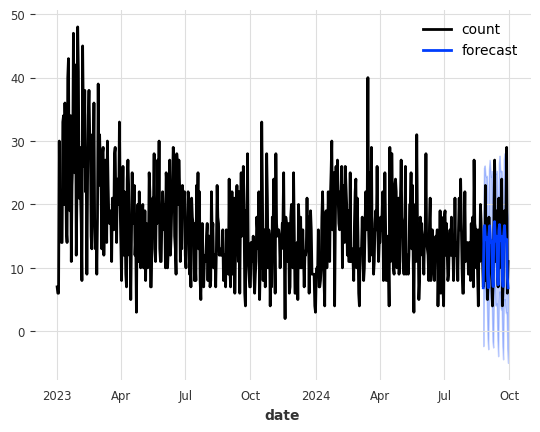

In [25]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [26]:
from darts.ad import KMeansScorer

scorer = KMeansScorer(k=2, window=5)
scorer.fit(train)
anom_score = scorer.score(val)

In [27]:
from darts.ad import QuantileDetector

detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train))
binary_anom = detector.detect(anom_score)

<Axes: xlabel='date'>

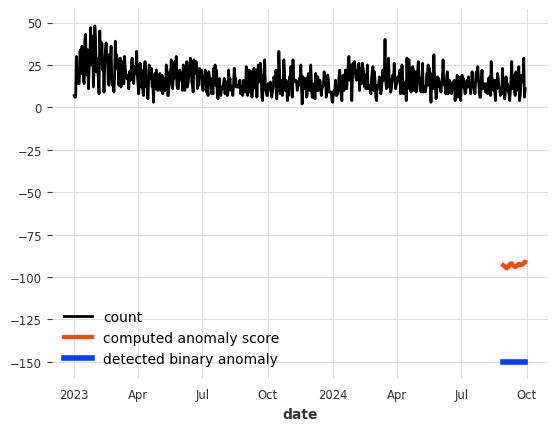

In [28]:
import matplotlib.pyplot as plt

series.plot()
(anom_score / 2.0 - 100).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * 45 - 150).plot(label="detected binary anomaly", lw=4)

In [29]:
%%capture
from darts.models import Prophet

models = [ExponentialSmoothing(), Prophet()]

backtests = [
    model.historical_forecasts(series, start=0.5, forecast_horizon=3)
    for model in models
]

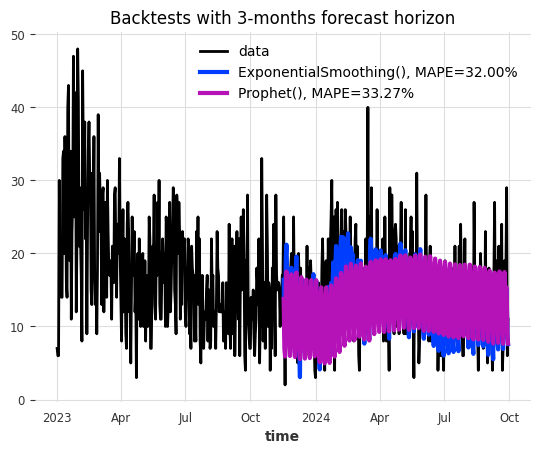

In [30]:
from darts.metrics import mape

series.plot(label="data")
for i, m in enumerate(models):
    err = mape(backtests[i], series)
    backtests[i].plot(lw=3, label="{}, MAPE={:.2f}%".format(m, err))

plt.title("Backtests with 3-months forecast horizon")
plt.legend()

Ещё есть библиотека интересная
https://skforecast.org/0.13.0/user_guides/backtesting.html